   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 13.9 MB/s eta 0:00:00
✅ Accuracy: 0.9455857856746253

📋 Classification Report:
                                       precision    recall  f1-score   support

                       Not_offensive       0.95      0.99      0.97      3201
     Offensive_Targeted_Insult_Group       0.78      0.23      0.36        30
Offensive_Targeted_Insult_Individual       0.83      0.49      0.62        49
               Offensive_Untargetede       0.68      0.40      0.50        43
                       not-malayalam       0.87      0.71      0.78       279

                            accuracy                           0.95      3602
                           macro avg       0.82      0.56      0.65      3602
                        weighted avg       0.94      0.95      0.94      3602

✅ Predictions with all labels saved to: /content/drive/MyDrive/Dataset/Malayalam/Mal_RandomForest_Results.csv


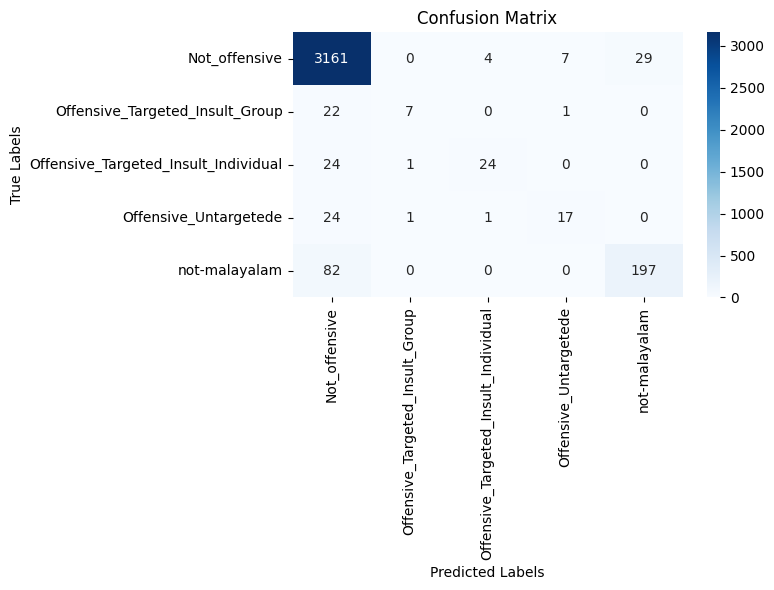

In [1]:
#RandomForest
# ==========================
# 1. Install & Import
# ==========================
!pip install emoji

import pandas as pd
import re
import emoji
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# 2. Load Datasets
# ==========================
train_path = "/content/drive/MyDrive/Dataset/Malayalam/mal_full_offensive_train.csv"
dev_path   = "/content/drive/MyDrive/Dataset/Malayalam/mal_full_offensive_dev.csv"
test_path  = "/content/drive/MyDrive/Dataset/Malayalam/mal_offensive_test_without_labels.csv"

df_train = pd.read_csv(train_path)
df_dev   = pd.read_csv(dev_path)
df_test  = pd.read_csv(test_path)

# Combine train + dev for full training
df = pd.concat([df_train, df_dev], ignore_index=True)

# ==========================
# 3. Cleaning Function
# ==========================
def clean_text(text):
    text = str(text)
    text = emoji.replace_emoji(text, replace='')  # Remove emojis
    text = re.sub(r"[^0-9A-Za-z\u0D00-\u0D7F\s]", " ", text)  # Malayalam + English + numbers
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["Cleaned_Text"] = df["Text"].apply(clean_text)
df_test["Cleaned_Text"] = df_test["Text"].apply(clean_text)

# ==========================
# 4. Train-Test Split (for validation)
# ==========================
X = df['Cleaned_Text']
y = df['Labels']   # Keep original labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================
# 5. TF-IDF Vectorization
# ==========================
vectorizer = TfidfVectorizer(max_features=8000)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec   = vectorizer.transform(X_val)

# ==========================
# 6. Train Random Forest
# ==========================
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_vec, y_train)

# ==========================
# 7. Validation Evaluation
# ==========================
y_pred_val = rf_model.predict(X_val_vec)
print("✅ Accuracy:", accuracy_score(y_val, y_pred_val))
print("\n📋 Classification Report:\n", classification_report(y_val, y_pred_val))

# ==========================
# 8. Confusion Matrix as Image
# ==========================
cm = confusion_matrix(y_val, y_pred_val, labels=rf_model.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf_model.classes_,
            yticklabels=rf_model.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()

# ==========================
# 9. Train Final Model on All Data
# ==========================
X_full_vec = vectorizer.fit_transform(df['Cleaned_Text'])
rf_model.fit(X_full_vec, df['Labels'])

# ==========================
# 10. Predict on Test Data
# ==========================
X_test_vec = vectorizer.transform(df_test['Cleaned_Text'])
test_predictions = rf_model.predict(X_test_vec)

df_test["labels"] = test_predictions
output_path = "/content/drive/MyDrive/Dataset/Malayalam/Mal_RandomForest_Results.csv"
df_test[["ID", "labels"]].to_csv(output_path, index=False)

print(f"✅ Predictions with all labels saved to: {output_path}")
